In [1]:
# Me and Jonty spent a lot of time understanding the question that was framed in the lab.

# In the end we decided to change things a little bit: we are predicting here if a film is a fiction or non-fiction film based on a series of categories.

# 1) Non-fiction films - Travel, Documentary, Sports
# 2) Fiction - all the other categories

# - the variables we selected to make such a predicted were: number of films rented, rental duration, rental rate, length and rating.

# Since it was predictable that the number of non-fiction films would be a minority compared to fiction films,
# we tried to address this unbalance as well.

# Importing the data from SQL by calling the query

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

········


In [3]:
## Import data into a dataframe

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
# data = pd.read_sql_query('SELECT * FROM loan', engine)
# data.head()

In [4]:
query = '''select f.name, fr.film_id, sum(fr.number_of_times_rented) as n_films_rented, fr.rental_duration, fr.rental_rate, fr.length, fr.rating
from films_category_name fr
join category f
on fr.category_id = f.category_id
group by film_id;'''



data_new = pd.read_sql_query(query, engine)

# Here we are just assigning fiction or non-fiction based on film category

In [5]:
def cleanOperation(x):
    x = x.lower()
    if 'action' in x:
        return "fiction"
    elif 'animation' in x:
        return 'fiction'
    elif 'children' in x:
        return 'fiction'
    elif 'classics' in x:
        return "fiction"
    elif 'comedy' in x:
        return 'fiction'
    elif 'drama' in x:
        return "fiction"
    elif 'family' in x:
        return 'fiction'
    elif 'foreign' in x:
        return 'fiction'
    elif 'games' in x:
        return "fiction"
    elif 'horror' in x:
        return 'fiction'
    elif 'music' in x:
        return 'fiction'
    elif 'new' in x:
        return "fiction"
    elif 'sci-fi' in x:
        return 'fiction'
    else:
        return 'non-fiction'

In [6]:
data_new['fiction or non-fiction'] = list(map(cleanOperation, data_new['name']))

In [7]:
data_new.head()

,name,film_id,n_films_rented,rental_duration,rental_rate,length,rating,fiction or non-fiction
0,Action,19,20.0,6,0.99,113,PG,fiction
1,Action,21,21.0,3,4.99,129,R,fiction
2,Action,29,10.0,5,2.99,168,NC-17,fiction
3,Action,56,18.0,6,2.99,129,G,fiction
4,Action,67,20.0,5,2.99,77,PG-13,fiction


In [8]:
# We don't really need film_id and name columns:

In [9]:
data_new = data_new.drop(["film_id", 'name'], axis=1)

In [10]:
# Huge class imbalance, as predicted

data_new['fiction or non-fiction'].value_counts()

fiction        769
non-fiction    189
Name: fiction or non-fiction, dtype: int64

# Normalization of numerical variables

In [11]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = data_new.select_dtypes(include = np.number)

column_names=list(x.columns)

# Normalizing data
transformer = Normalizer().fit(x)
x_normalized = transformer.transform(x)
data_numerical_transformed = pd.DataFrame(x_normalized)

data_numerical_transformed.columns=column_names

In [12]:
data_numerical_transformed.head()

,n_films_rented,rental_duration,rental_rate,length
0,0.174038,0.052211,0.008615,0.983316
1,0.160516,0.022931,0.038142,0.986029
2,0.059383,0.029692,0.017756,0.997636
3,0.138013,0.046004,0.022926,0.989096
4,0.250727,0.062682,0.037484,0.965299


# Dummifying the only categorical feature - rating

In [13]:
cat = data_new.select_dtypes(include = np.object)

cat = cat.drop(['fiction or non-fiction'], axis=1)
categorical = pd.get_dummies(cat, columns=['rating'])

# Train-test split

In [14]:
y = data_new['fiction or non-fiction']
X = np.concatenate((x, categorical), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [15]:
import sklearn
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs', max_iter=5000).fit(X_train, y_train)

# Validating the model

In [16]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.85


In [17]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8515625

In [18]:
y_test.value_counts()

fiction        327
non-fiction     57
Name: fiction or non-fiction, dtype: int64

# Confusion matrix for the prediction

In [19]:
sklearn. __version__ 

'0.23.2'

In [20]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[327,   0],
       [ 57,   0]], dtype=int64)

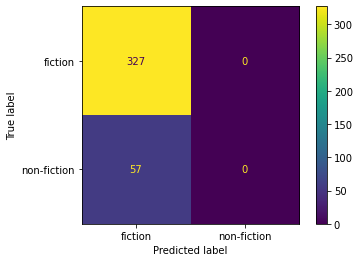

In [21]:
plot_confusion_matrix(classification, X_test, y_test)

In [ ]:
# As expected, because of the huge class imbalance, we can't make any predictions about non-fiction.
# We tried to address this by playing around with downsampling

# Here we tried to downsample "fiction"

In [22]:
query = '''select f.name, fr.film_id, sum(fr.number_of_times_rented) as n_films_rented, fr.rental_duration, fr.rental_rate, fr.length, fr.rating
from films_category_name fr
join category f
on fr.category_id = f.category_id
group by film_id;'''



data_new2 = pd.read_sql_query(query, engine)


In [23]:
data_new2['fiction or non-fiction'] = list(map(cleanOperation, data_new2['name']))

In [24]:
data_new2 = data_new2.drop(["film_id", 'name'], axis=1)

In [25]:
data_new2['fiction or non-fiction'] = [1 if b=='fiction' else 0 for b in data_new2['fiction or non-fiction']]

In [26]:
from sklearn.utils import resample

In [27]:
data_new2_minority = data_new2[data_new2['fiction or non-fiction']==0]
data_new2_majority = data_new2[data_new2['fiction or non-fiction']==1]
 
# Downsample majority class
df_majority_downsampled = resample(data_new2_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=189,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, data_new2_minority])
 
# Display new class counts
df_downsampled['fiction or non-fiction'].value_counts()

1    189
0    189
Name: fiction or non-fiction, dtype: int64

In [28]:
df_downsampled.shape

(378, 6)

In [29]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = df_downsampled[["n_films_rented", "rental_duration", "rental_rate", "length"]]

column_names=list(x.columns)

# Normalizing data
transformer = Normalizer().fit(x)
x_normalized = transformer.transform(x)
data_numerical_transformed = pd.DataFrame(x_normalized)

data_numerical_transformed.columns=column_names

data_numerical_transformed.head()

,n_films_rented,rental_duration,rental_rate,length
0,0.161041,0.026840,0.020063,0.986379
1,0.102800,0.027413,0.034198,0.993736
2,0.182789,0.034273,0.011310,0.982490
3,0.169219,0.030218,0.005983,0.985097
4,0.135199,0.043018,0.030666,0.989409


In [31]:
# Dummifying categorical features

cat = df_downsampled.select_dtypes(include = np.object)

categorical = pd.get_dummies(cat, columns=['rating'])
categorical.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
617,0,0,0,1,0
392,0,0,0,1,0
36,1,0,0,0,0
200,0,0,0,0,1
548,0,0,0,0,1


In [32]:
## Train-test split

y = df_downsampled['fiction or non-fiction']
X = np.concatenate((x, categorical), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

import sklearn
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(max_iter=5000).fit(X_train, y_train) #multiclass = multinomial, because our cat. feature can have more than 2 values.

In [33]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.51


In [34]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.506578947368421

In [35]:
y_test.value_counts()

1    80
0    72
Name: fiction or non-fiction, dtype: int64

In [36]:
sklearn. __version__ 

'0.23.2'

In [37]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[44, 28],
       [47, 33]], dtype=int64)

In [38]:
## Getting the confussion matrix

sklearn. __version__ 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[44, 28],
       [47, 33]], dtype=int64)

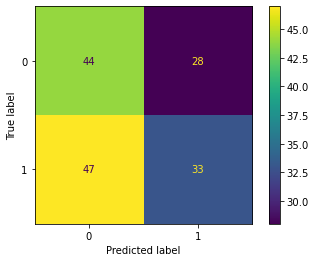

In [39]:
plot_confusion_matrix(classification, X_test, y_test)